In [51]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn import datasets

iris = datasets.load_iris()
digits = datasets.load_digits()

def adjust_fontsize(ax):
    for ax in ax:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
                     + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(14)  
            
            
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))   



**GOAL:** take original script and make function such that user can chose both number of layers and number of neurons per layer!

## Forward pass

![alt text](https://github.com/jphreid/tutorial_ivado/raw/master/lstm_finance.003.jpeg)


In [52]:
print("Features:", iris.feature_names, iris.data.shape, end="\n\n")
print("Labels:", iris.target_names, iris.target.shape)

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] (150, 4)

Labels: ['setosa' 'versicolor' 'virginica'] (150,)


In [53]:
# A single example.
x = iris.data[0]
y = iris.target[0]
print("x:", x, end="\n\n")
print("y:", y)

x: [5.1 3.5 1.4 0.2]

y: 0


In [54]:
W_1 = np.random.uniform(-1, 1, (10, 4))
print(W_1)

[[ 0.86249978 -0.83952537  0.68466271 -0.34781907]
 [-0.77274399 -0.25087608  0.45748387  0.38275012]
 [ 0.04572353 -0.32697252  0.56282737 -0.20858987]
 [ 0.65415144 -0.35575912 -0.57355445 -0.13939552]
 [-0.5172424   0.88742765 -0.9258287  -0.22632798]
 [-0.59822895 -0.82181894 -0.59184015  0.29290204]
 [ 0.7484534   0.24830764 -0.06207525  0.26115151]
 [ 0.82522023 -0.56538379 -0.17030552 -0.42541007]
 [-0.66164448 -0.09747203  0.85350341  0.23328863]
 [-0.18472695 -0.814822    0.8811886   0.08641164]]


In [55]:
# Random initialization 
# 10, 20 - hyperparams
W_1 = np.random.uniform(-1, 1, (10, 4)) # 10 x 4 array, random num, range -1 to 1
h_1 = np.dot(W_1, x) # W: 10 x 4, x: 4 x 1, h1: 10 x 1

W_2 = np.random.uniform(-1, 1, (20, 10))
h_2 = np.dot(W_2, h_1)

W_3 = np.random.uniform(-1, 1, (3, 20))
o = np.dot(W_3, h_2)
print(o)



[ 26.60065965 -21.39788333  -2.99264288]


In [56]:
softmax(np.dot(W_3, np.dot(W_2, np.dot(W_1, x))))

array([1.00000000e+00, 1.42724209e-21, 1.40537430e-13])

In [57]:
input_size = len(iris.feature_names) #4
hidden_size = 20
target_size = 3

In [58]:
# First layer parameters.
W_1 = np.random.uniform(-1, 1, (hidden_size, input_size))
b_1 = np.zeros(hidden_size)
print("W_1 of shape {}".format(W_1.shape))

W_1 of shape (20, 4)


In [59]:
# Second layer parameters.
W_2 = np.random.uniform(-1, 1, (target_size, hidden_size))
b_2 = np.zeros(target_size)
print("W_2 of shape", W_2.shape)


W_2 of shape (3, 20)


In [60]:
# First hidden layer representation.
hidden_layer = np.tanh(np.dot(W_1, x)) + b_1


print("hidden_layer_1 of shape {}".format(hidden_layer.shape))

hidden_layer_1 of shape (20,)


In [61]:
# Output layer representation.
output = np.dot(W_2, hidden_layer) + b_2

print("output: {}".format(output.shape))

output: (3,)


In [62]:
# Output layer representation after applying softmax.

prob = softmax(output)
print(prob)

# Predicted class.
y_pred = np.argmax(prob)
print("y_pred: {}".format(y_pred))

[0.86041239 0.07341022 0.06617739]
y_pred: 0


In [63]:
-np.log(prob)

array([0.15034348, 2.61169206, 2.71541648])

## Backpropagation

In [64]:
all_data = np.concatenate((iris.data, iris.target.reshape(150, 1)), axis=1)
np.random.shuffle(all_data)
x = all_data[:100, :4]
y = all_data[:100, 4].astype(int)

xt = all_data[100:, :4]
yt = all_data[100:, 4].astype(int)

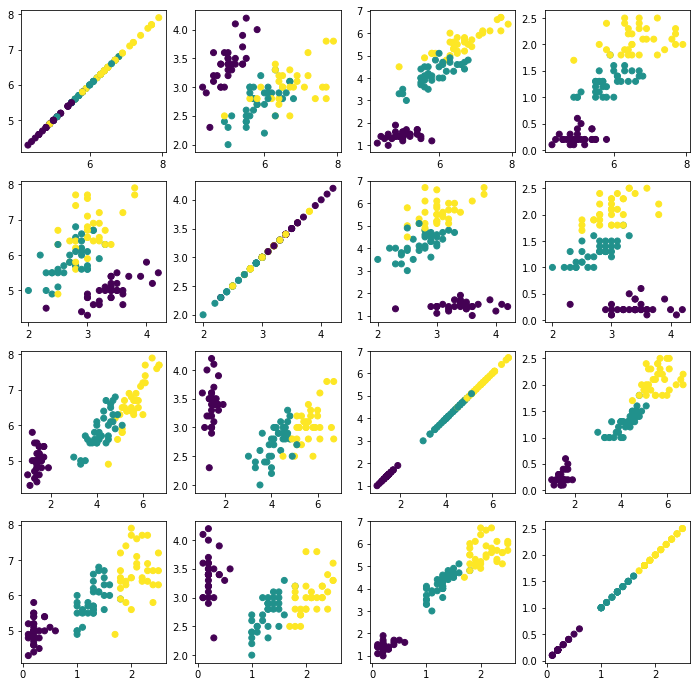

In [65]:
fig, ax = plt.subplots(4,4,figsize=(12,12))

for i in range(4):
    for j in range(4):
        ax[i, j].scatter(x[:, i], x[:, j], c=y, marker='o')

plt.show()

In [66]:
def relu(x):
    return x * (x > 0)

def softmax(x):
    
    return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(x.shape[0], 1)


class MLP():
    def __init__(self, h1):
        self.h1 = h1
        self.w1 = np.random.rand(h1, 4)
        self.w2 = np.random.rand(3, h1)
        self.b1 = np.zeros(h1, None)
        self.b2 = np.zeros(3, None)
    
    def forward(self, xx):
        self.ha = xx.dot(self.w1.T) + self.b1
        self.hs = relu(self.ha)
        self.oa = self.hs.dot(self.w2.T) + self.b2         
        self.os = softmax(self.oa)
        
        return self.os
    
    def loss(self, xx, yy):
        return np.choose(yy[None, :], -np.log(self.forward(xx).T))

    def backward(self, xx, yy):
        self.grad_oa = (self.os - np.eye(3)[yy])
        self.grad_w2 = self.grad_oa.T.dot(self.hs)
        self.grad_b2 = np.sum(self.grad_oa, axis=0)
        self.grad_hs = self.grad_oa.dot(self.w2)
        self.grad_ha = np.where(self.ha > 0, self.grad_hs , 0)
        self.grad_w1 = self.grad_ha.T.dot(xx)
        self.grad_b1 = np.sum(self.grad_ha, axis=0)
        self.grad_x = np.sum(self.grad_ha.dot(self.w1), axis=1)

        return self.grad_oa, self.grad_w2, self.grad_b2, self.grad_hs, self.grad_ha, self.grad_w1, self.grad_b1, self.grad_x
    
    def update(self, eta):
        self.w1 = self.w1 - eta*self.grad_w1
        self.b1 = self.b1 - eta*self.grad_b1
        self.w2 = self.w2 - eta*self.grad_w2
        self.b2 = self.b2 - eta*self.grad_b2

In [67]:
model = MLP(10)

In [68]:
print('Finite difference')
print('=================')
eps = 1e-5
grad_x = (model.loss(x + eps, y) - model.loss(x, y))/1e-5
print(grad_x[:, :5])

print()

print('Backpropagation')
print('=================')

grad_oa, grad_w2, grad_b2, grad_hs, grad_ha, grad_w1, grad_b1, grad_x = model.backward(x, y)
print(grad_x[:5])


print()
print('They are the same! ')
print()

Finite difference
[[-0.02112157  1.70520221 -0.03985561  4.09670856 -0.02774914]]

Backpropagation
[-0.02112174  1.70520219 -0.03985594  4.09670855 -0.02774938]

They are the same! 



## Training

In [69]:
# could do minibatch instead. 
losses = []
for i in range(10000):
    output = model.forward(x)
    pred = np.argmax(output, axis=1)
    loss = np.sum(model.loss(x, y))

    grads = model.backward(x, y)
    model.update(0.0001)
    losses.append(loss)
    if i%1000==0:
        print(loss)

808.1151552432497
14.731064635225001
9.246600224072717
7.643611637952111
6.8765513106765335
6.404562377887787
6.068085235176909
5.802299854704396
5.577954360725753
5.379915201272436


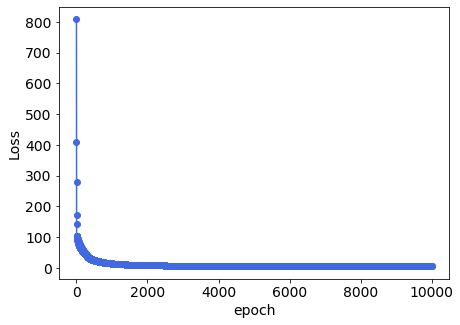

In [70]:
fig = plt.figure(figsize=(7, 5))
plt.plot(losses, 'o-', color='royalblue')
plt.xlabel('epoch')
plt.ylabel('Loss')
adjust_fontsize(fig.axes)
plt.show()

In [25]:
output = model.forward(xt) # xt test, yt test
pred_t = np.argmax(output, axis=1)
print('Test accuracy: {}%'.format(100*(1-(np.sum(np.abs(pred_t - yt))/yt.shape[0]))))

Test accuracy: 96.0%
